First, load the data, from the supplied data file

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re
import seaborn as sns
from collections import Counter

import time
import folium
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable

In [3]:
# Import the data
df = pd.read_csv("../data/artist_data.csv")  #..(relative path, goes to the parent directory) vs. C:Users (absolute path)


In [4]:
# Set some global options so we always see all of the columns and rows when we print something out
pd.set_option('display.max_columns', 100) # 100 cols
pd.set_option('display.max_rows', 50) # 50 rows
print(df.head)

In [6]:
# Shape and data types of the data
print(df.shape) 
print("The dataframe has",df.shape[0],"rows and", df.shape[1],"columns")
print(df.dtypes) # The data types of all of the columns

# select numeric columns
df_numeric = df.select_dtypes(include=[np.number]) # Select numeric data types
numeric_cols = df_numeric.columns.values # Give the column names to a new variable
print("The column names are",df.columns.values)
print("The numeric columns are", numeric_cols)

# select non numeric columns
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print("The non-numeric columns are",non_numeric_cols)

(3532, 9)
The dataframe has 3532 rows and 9 columns
id                int64
name             object
gender           object
dates            object
yearOfBirth     float64
yearOfDeath     float64
placeOfBirth     object
placeOfDeath     object
url              object
dtype: object
The column names are ['id' 'name' 'gender' 'dates' 'yearOfBirth' 'yearOfDeath' 'placeOfBirth'
 'placeOfDeath' 'url']
The numeric columns are ['id' 'yearOfBirth' 'yearOfDeath']
The non-numeric columns are ['name' 'gender' 'dates' 'placeOfBirth' 'placeOfDeath' 'url']


Identify missing data 

<Axes: >

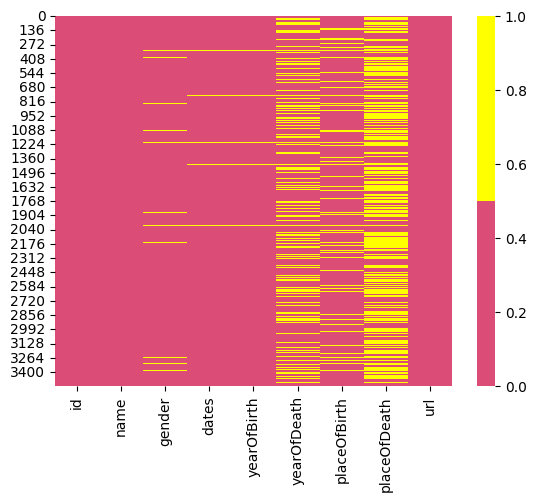

In [7]:
cols = df.columns[:30] # Select the first 30 columns
colours = ['#db4c77', '#ffff00'] # Specify the colours, where yellow is missing and pink is not missing.
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours)) # Make a heatmap


Some colums are not too important in this analysis, therefore I am going to drop the 'Place of death' and 'Year of Death' and 'url'.

In [8]:
# cols_to_drop = ['placeOfDeath', 'url', 'yearOfDeath', 'id', 'dates']
# df_col_dropped = df.drop(cols_to_drop, axis=1)
# df_col_dropped

### Location sorting and cleaning
Reduce the number of categories for 'placeOfBirth, keep only the top 10 places with most data, and label the rest as 'Other'

In [14]:
top_places = df['placeOfBirth'].value_counts().index[:20]
df['placeOfBirth20'] = df['placeOfBirth'].where(df['placeOfBirth'].isin(top_places), 'Other')

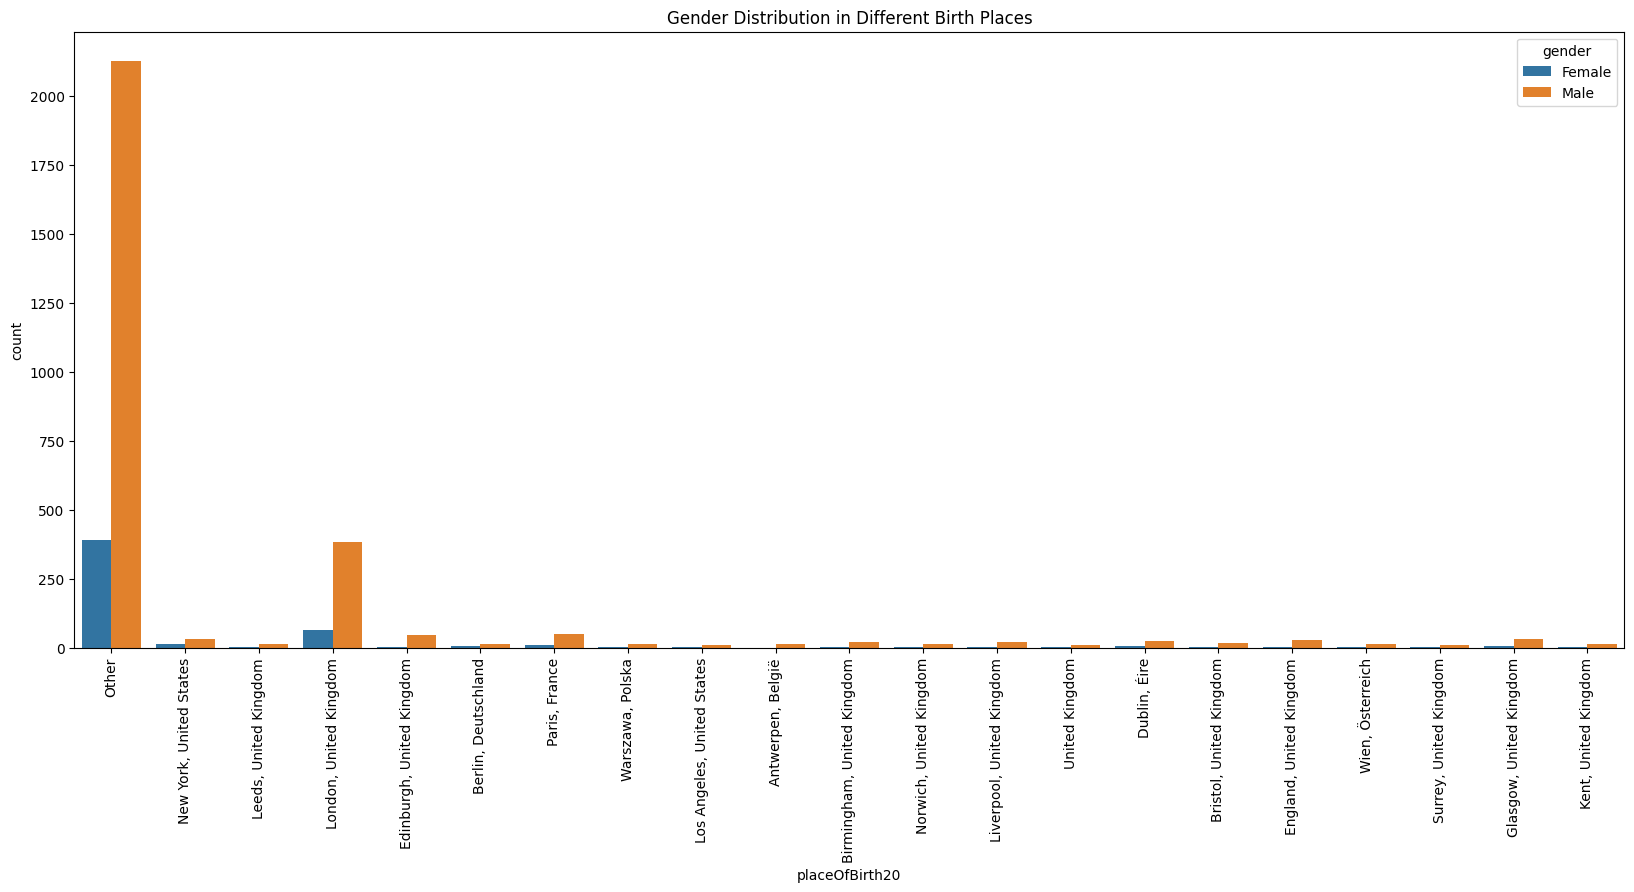

In [15]:
# Count Plot
plt.figure(figsize=(20, 8))
sns.countplot(data=df, x='placeOfBirth20', hue='gender')
plt.xticks(rotation=90)
plt.title("Gender Distribution in Different Birth Places")
plt.show()

The above locations are hard to map, so I am going to pull out the locations and split the conutry and the cities. 

In [16]:
df_tidy_location = df['placeOfBirth'].str.split(', ', expand=True)

# Display the DataFrame
print(df_tidy_location)

                   0               1     2
0             Polska            None  None
1       Philadelphia   United States  None
2        Springfield   United States  None
3     Leicestershire  United Kingdom  None
4              Wigan  United Kingdom  None
...              ...             ...   ...
3527   Andorno Micca          Italia  None
3528      Des Moines   United States  None
3529          Italia            None  None
3530          España            None  None
3531          Polska            None  None

[3532 rows x 3 columns]


In [17]:
df_map3 = df_tidy_location.rename(columns={0: 'city', 1: 'country'})
df_map3

,city,country,2
0,Polska,None,None
1,Philadelphia,United States,None
2,Springfield,United States,None
3,Leicestershire,United Kingdom,None
4,Wigan,United Kingdom,None
...,...,...,...
3527,Andorno Micca,Italia,None
3528,Des Moines,United States,None
3529,Italia,None,None
3530,España,None,None


In [157]:
# Count the occurrences of each unique value in the 'city' and 'country' columns
city_counts = df_map3['city'].value_counts()
country_counts = df_map3['country'].value_counts()

# Display the most frequent city and country
most_frequent_city = city_counts.idxmax()
most_frequent_country = country_counts.idxmax()

print(f"The most frequent city is {most_frequent_city} with {city_counts.max()} occurrences.")
print(f"The most frequent country is {most_frequent_country} with {country_counts.max()} occurrences.")

The most frequent city is London with 449 occurrences.
The most frequent country is United Kingdom with 1481 occurrences.


In [158]:
# # Get the top 200 cities and countries
# top_200_cities = city_counts.head(200)
# top_200_countries = country_counts.head(200)

# # Display the top 200 cities and countries
# print("Top 200 Cities:")
# print(top_200_cities)

# print("\nTop 200 Countries:")
# print(top_200_countries)

In [159]:
# Combine city and country columns
city_country_combined = df_map3['city'] + '|' + df_map3['country'].fillna('')

# Count the occurrences of each unique city/country combination
city_country_counts = Counter(city_country_combined)

# Sort by counts and get the top 200
top_200 = city_country_counts.most_common(200)

# Create a new DataFrame with the columns: city, country, and frequency
top_200_df = pd.DataFrame(top_200, columns=['city|country', 'frequency'])
top_200_df[['city', 'country']] = top_200_df['city|country'].str.split('|', expand=True)
top_200_df.drop(columns=['city|country'], inplace=True)

print(top_200_df)


     frequency             city         country
0          492              NaN             NaN
1          446           London  United Kingdom
2           57            Paris          France
3           47        Edinburgh  United Kingdom
4           43         New York   United States
..         ...              ...             ...
195          3  North Yorkshire  United Kingdom
196          3         Cornwall  United Kingdom
197          3      Kansas City   United States
198          3      Minneapolis   United States
199          3            Nihon                

[200 rows x 3 columns]


### Map the Map

Now I am going to map the new data frame using folium.

In [168]:
# Initialize geolocator
geolocator = Nominatim(user_agent="city_mapper")

# Function to get latitude and longitude
def get_lat_lon(city, country):
    try:
        location = geolocator.geocode(f"{city}, {country}")
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except Exception as e:
        print(f"Error: {e}")
        return None, None

In [169]:
# Get latitude and longitude for each city and store in the DataFrame
latitudes = []
longitudes = []
for index, row in top_200_df.iterrows():
    lat, lon = get_lat_lon(row['city'], row['country'])
    latitudes.append(lat)
    longitudes.append(lon)
    time.sleep(1) # To avoid hitting rate limits of the geocoding service

In [172]:
# Add latitude and longitude columns to DataFrame
top_200_df['latitude'] = latitudes
top_200_df['longitude'] = longitudes

# Create a map centered at some location
map = folium.Map(location=[10, 0], zoom_start=2)

# Filter out rows with NaN latitude or longitude
valid_locations = top_200_df.dropna(subset=['latitude', 'longitude'])



In [174]:
# Add city data to the map
for index, row in valid_locations.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']], popup=f"{row['city']}, {row['country']}").add_to(map)

# Display the map
map